In [1]:
laptop = True

if laptop:
    rootF = 'C:/Users/goethas/'
else:
    rootF = '/home/sarah/'

In [2]:
import os
import sys
from matplotlib.pyplot import *
from numpy import *
from tqdm.auto import tqdm
import itertools
import csv
import h5py
import matplotlib.gridspec as gds
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pickle
import pandas as pd
import matplotlib.patches as pcs


# Import diverse functions
from shared.functions import fit_gaussian, get_ellipse_parameters, plot_dendrogram
from shared.save_load import *

sys.path.append(rootF + '/Documents/GitHub/Stimuli-Generation/Checkerboard/')
from checkerboard import Checkerboard

# For clustering
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

In [3]:
exp = 20211207

# Load data

Loading pre-processed data.
'Cell_data' is a dictionary whose keys are the cells number and that contains : 'isi', 'templates', 'spike times' (Euler), 'spike trains' (Euler), 'psth' (Euler), 'sta', 'temporal_sta' (checkerboard), 'spatial_sta' (checkerboard), 'polarity' (checkerboard)

In [4]:
data_path = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/'

cell_data = load_obj(data_path + 'cells_characterization_data_NEW_' + str(exp))

good_clusters = list(cell_data.keys())

print (len(good_clusters), 'clusters')
print (good_clusters)

193 clusters
[2, 3, 6, 9, 18, 25, 26, 33, 40, 41, 44, 45, 48, 49, 52, 59, 60, 61, 63, 64, 65, 66, 69, 70, 73, 74, 77, 85, 88, 89, 95, 98, 100, 103, 104, 107, 110, 114, 120, 129, 132, 141, 142, 145, 146, 148, 149, 151, 155, 157, 160, 161, 165, 171, 172, 176, 179, 182, 183, 184, 186, 193, 196, 197, 205, 210, 216, 217, 218, 220, 224, 229, 230, 235, 240, 244, 246, 247, 249, 253, 262, 263, 265, 267, 269, 272, 275, 277, 278, 282, 283, 291, 298, 302, 303, 305, 308, 310, 314, 315, 316, 326, 328, 339, 340, 342, 347, 349, 350, 358, 359, 361, 363, 366, 367, 368, 372, 377, 378, 381, 382, 383, 386, 387, 388, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 405, 406, 414, 415, 416, 417, 418, 419, 420, 421, 424, 426, 427, 428, 430, 433, 435, 436, 437, 444, 447, 458, 459, 461, 462, 463, 470, 471, 472, 474, 476, 479, 491, 495, 497, 498, 501, 502, 506, 507, 509, 513, 515, 529, 538, 552, 573, 575, 579, 582, 583, 584, 585, 587, 589, 591, 595]


### Select the cells that have a spatial STA

In [5]:
if laptop:
    results_path = 'C:/Users/goethas/Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/'
else:
    results_path = '/home/sarah/Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/'
    
cluster_selection = pd.read_excel(results_path + str(exp) + '_cluster_selection_NEW.xlsx', header=0)

cluster_names = cluster_selection['Cluster']
selection = cluster_selection['Selected']
defined_STA = cluster_selection['Comments Sarah']
STA_start = cluster_selection['Spatial STA']
STA_end = cluster_selection['Sp STA END']

skip_cells = [] # very low firing rate during chirp

# Select "YES" cells with a spatial STA
selected_cells = []
which_STA = []

for i in range(len(cluster_names)):
    if cluster_names[i] not in skip_cells and selection[i] == 'YES' and defined_STA[i] != 'no STA':
        if STA_start[i] == 0:
            print (cluster_names[i], 'end')
            which_STA.append('end')
            selected_cells.append(cluster_names[i])
        else:
            print (cluster_names[i], 'start')
            which_STA.append('start')
            selected_cells.append(cluster_names[i])
            
        
print (len(selected_cells), 'good cells!')

6 start
26 end
33 start
41 start
44 start
45 start
52 start
59 start
60 start
61 start
63 start
64 start
65 start
69 start
77 start
85 end
89 start
95 start
98 start
100 start
103 end
107 start
110 start
114 start
120 start
129 start
141 end
145 end
148 start
149 start
155 start
160 start
161 start
165 start
179 start
182 start
183 start
184 start
186 start
197 start
205 start
210 start
217 start
218 start
220 start
229 start
235 start
240 end
246 end
247 start
249 start
253 start
265 start
267 start
269 start
272 start
277 start
278 start
283 start
298 start
302 end
303 start
310 start
315 start
316 start
326 start
328 start
340 end
342 start
359 start
363 start
378 start
381 start
392 start
393 start
394 start
395 start
396 start
398 start
399 start
402 end
405 start
406 end
414 start
416 end
417 start
418 start
421 start
426 start
433 start
435 start
437 start
444 end
458 start
459 start
462 start
471 start
472 start
476 start
479 start
491 start
498 start
501 start
506 start
507 st

# Get ellipses

In [6]:
for cell_index in range(len(selected_cells)):
    cell_id = selected_cells[cell_index]
    
    ### Spatial STA
    if which_STA[cell_index] == 'start':
        spatial = cell_data[cell_id]['spatial_sta']
    elif which_STA[cell_index] == 'end':
        spatial = cell_data[cell_id]['spatial_sta2']
        
    # Gaussian fit
    x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(spatial)

    # Get ellipse parameters
    factor_sigma = 2 # TODO: correct?
    x0, y0, width, height, angle = get_ellipse_parameters(parameters, factor=factor_sigma)
    
    cell_data[cell_id]["ellipseSigmaXY"] = width, height

C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

# Cell typing

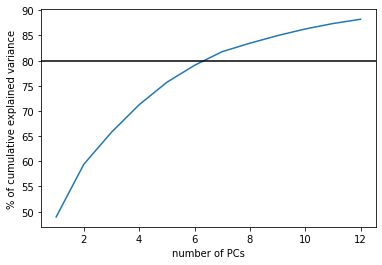

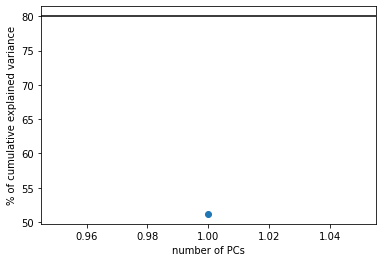

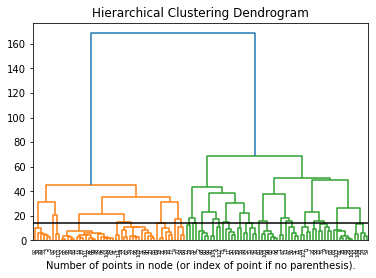

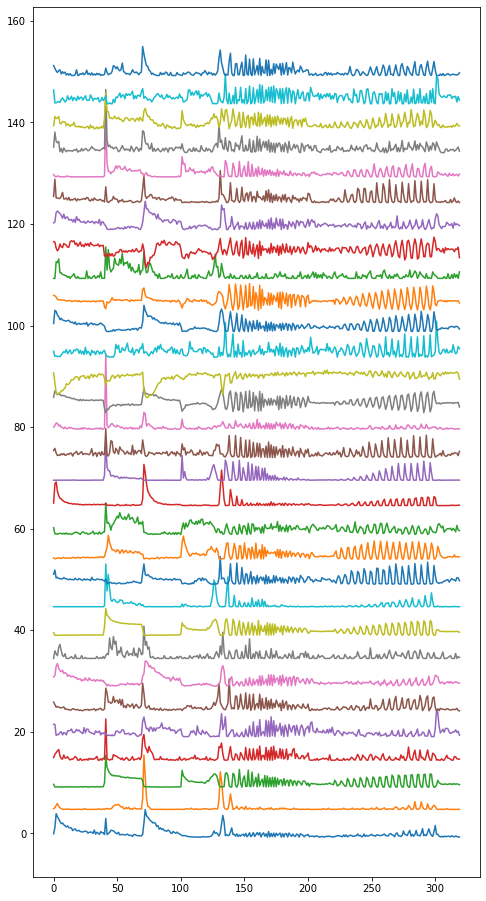

Number of clusters:  31
cluster size : 5


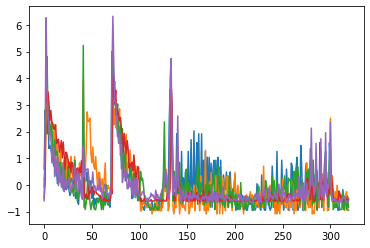

cluster size : 5


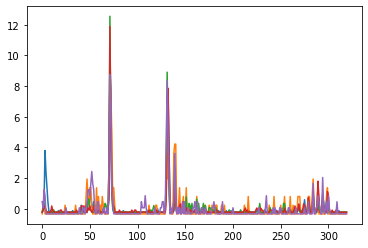

cluster size : 12


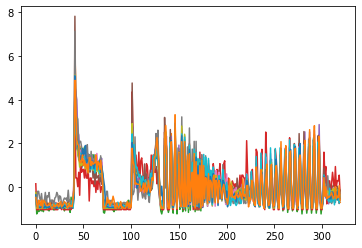

cluster size : 3


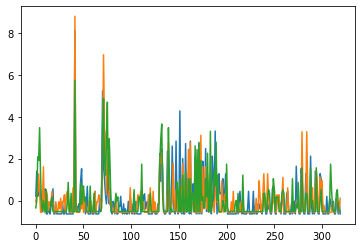

cluster size : 2


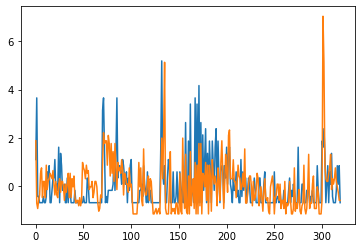

cluster size : 2


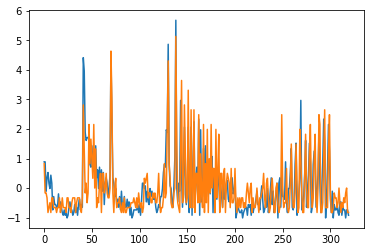

cluster size : 4


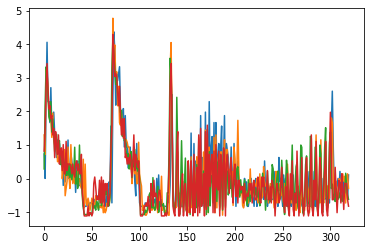

cluster size : 2


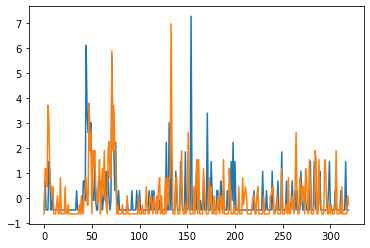

cluster size : 18


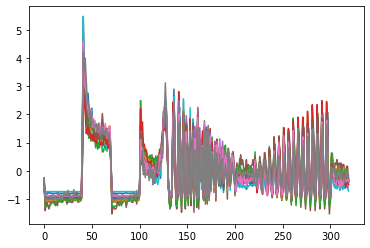

cluster size : 3


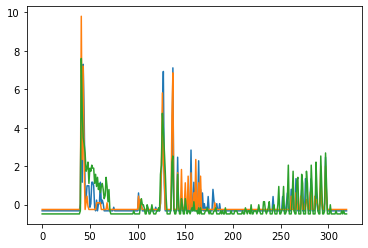

cluster size : 4


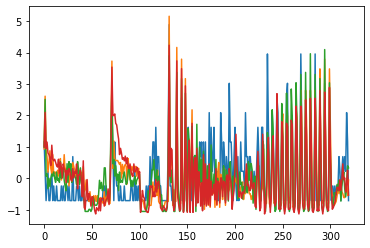

cluster size : 6


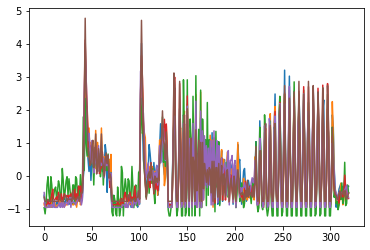

cluster size : 2


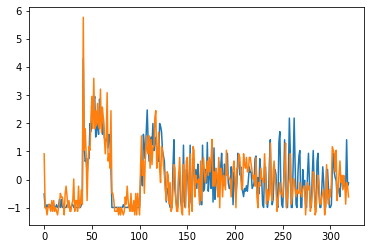

cluster size : 7


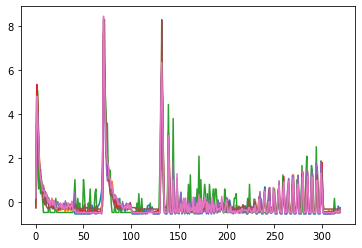

cluster size : 5


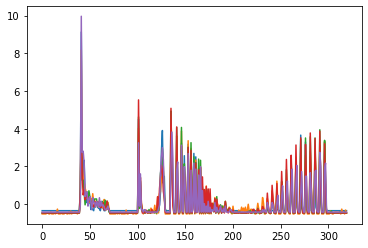

cluster size : 4


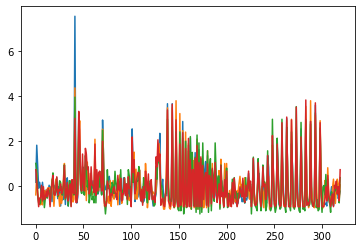

cluster size : 4


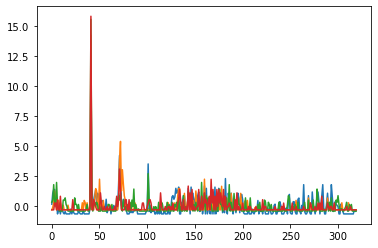

cluster size : 6


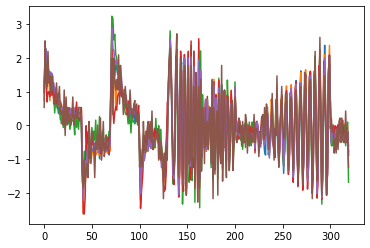

cluster size : 1


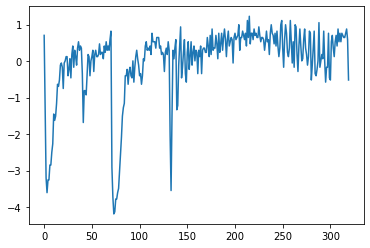

cluster size : 1


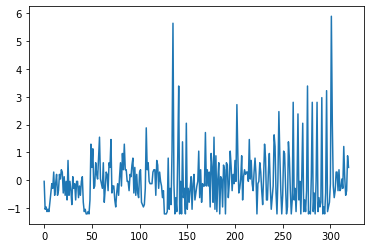

cluster size : 2


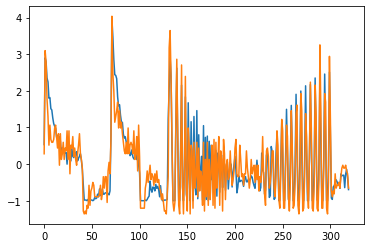

cluster size : 2


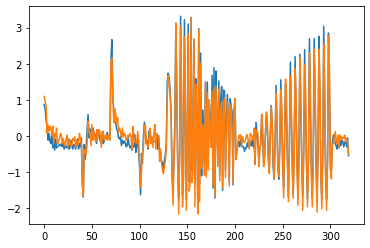

cluster size : 1


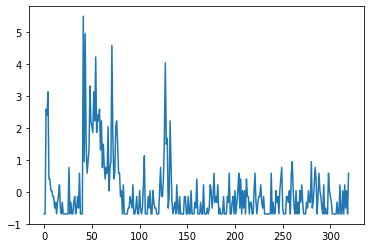

cluster size : 1


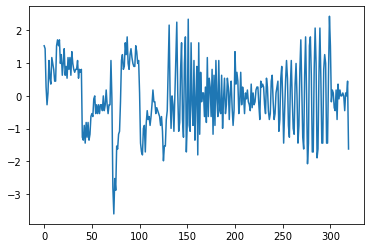

cluster size : 2


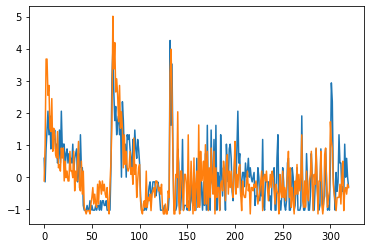

cluster size : 1


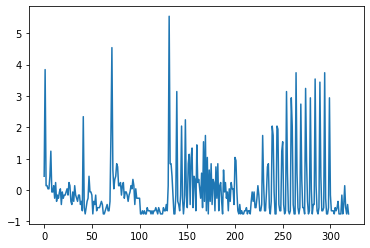

cluster size : 2


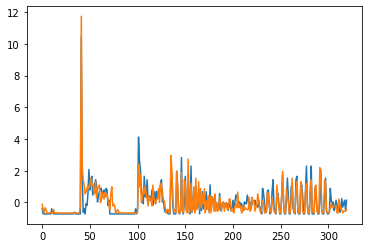

cluster size : 1


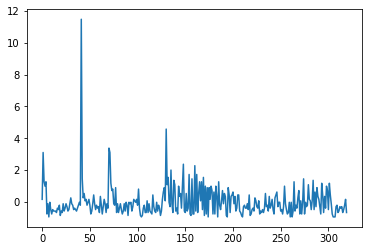

cluster size : 1


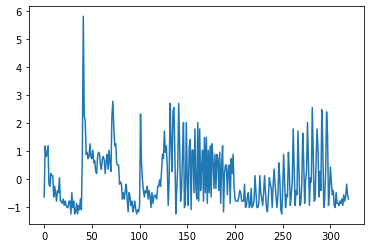

cluster size : 1


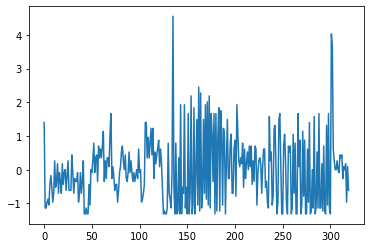

cluster size : 2


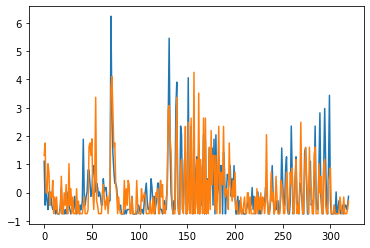

In [7]:
import scipy as sc
from sklearn.decomposition import SparsePCA
sparse=False

# change dist_thres to adapt the cut of the dendrogram and select the number of clusters
#####################################################################
dist_thres = 14 # 14 is the chosen value for exp 20211207
#####################################################################

n_cells = len(selected_cells)

#-----------------------------------
#-----------------------------------
# Get Euler PCA
n_rep = 20 # nb of repeats
nt = 32 # total length
dt = 0.1 # bin size
if exp==22: 
    nt=40
    dt=0.125
time_bins = np.arange(0,nt+dt,dt)

spikes = np.zeros((n_cells, int(nt/dt), n_rep))
for cell_index in range(len(selected_cells)):
    cell_id = selected_cells[cell_index]
    spike_cell = cell_data[cell_id]["spike_trains"]
    for rep in range(n_rep):
        temp=np.histogram(spike_cell[rep], bins=time_bins)
        spikes[cell_index,:,rep] = temp[0]

#-------------------------
# Pre process the PSTH
psth = np.mean(spikes, 2)
psth_z = sc.stats.zscore(psth, 1)

# Select number of PCs to keep (here 13 explain ~80% of the variance)
#####################################################################
n_components_psth = 12  #13#16
#####################################################################
if sparse:
   pca_transformer = SparsePCA(n_components_psth, random_state=0).fit(psth_z)
else:
   pca_transformer = PCA(n_components_psth).fit(psth_z)
psth_pca = pca_transformer.transform(psth_z)
# -----------------------------------
# -----------------------------------
# Get checkerboard STA PCA
STA_time_course = np.zeros((n_cells, 40))  # 40 data points for these STAs
for cell_index in range(len(selected_cells)):
    cell_id = selected_cells[cell_index]
    if which_STA[cell_index] == 'start':
        TempSTA_cell = cell_data[cell_id]["temporal_sta"]
    elif which_STA[cell_index] == 'end':
        TempSTA_cell = cell_data[cell_id]["temporal_sta2"]
    STA_time_course[cell_index] = TempSTA_cell
    
#---------------------------
# Pre process the STA
sta_tc = sc.stats.zscore(STA_time_course[:,:], 1)
#####################################################################
n_components_sta_tc = 1
#####################################################################
if n_components_sta_tc>0:
    pca_transformer2 = PCA(n_components_sta_tc).fit(sta_tc)
    sta_tc_pca = pca_transformer2.transform(sta_tc)
#-----------------------------------
#-----------------------------------
if not sparse:
    plt.plot(np.arange(n_components_psth)+1, np.cumsum(pca_transformer.explained_variance_ratio_)*100)
    plt.axhline(y=80, color='k')
    plt.xlabel('number of PCs')
    plt.ylabel('% of cumulative explained variance')
    plt.show()

    if n_components_sta_tc>0:
        plt.plot(np.arange(n_components_sta_tc)+1, np.cumsum(pca_transformer2.explained_variance_ratio_)*100,'o-')
        plt.axhline(y=80, color='k')
        plt.xlabel('number of PCs')
        plt.ylabel('% of cumulative explained variance')
        plt.show()
#-----------------------------------
#-----------------------------------
cluster_dataset = np.zeros((n_cells, n_components_psth+n_components_sta_tc+1))
cluster_dataset[:,:n_components_psth] = psth_pca
if n_components_sta_tc>0:
    cluster_dataset[:,n_components_psth:n_components_psth+n_components_sta_tc] = sta_tc_pca

ell_size=np.zeros(len(selected_cells))
for cell_index in range(len(selected_cells)):
    cell_id = selected_cells[cell_index]
    width,height = cell_data[cell_id]["ellipseSigmaXY"]
#     print (width, height)
    ell_size[cell_index] = np.abs(np.pi*width*height)
    
ell_size_temp = -np.ones(n_cells)
temp = ell_size[:]-ell_size[:].min()
ell_size_temp[:] = temp/temp.max()
cluster_dataset[:,-1] = ell_size_temp
#-----------------------------------
#-----------------------------------

# perform agglomerative clustering
model = AgglomerativeClustering(distance_threshold=dist_thres, n_clusters=None)
#model = model.fit(psth_pca)
model = model.fit(cluster_dataset)

# plot the dendrogram
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=0)
plt.axhline(dist_thres, color='k')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# plot the cluster centroids
n_clusts = len(np.unique(model.labels_))
plt.figure(figsize=(8,16))
for iclust in range(n_clusts):
    idx_cluster = np.where(model.labels_==iclust)[0]
    plt.plot(np.mean(psth_z[idx_cluster,:], 0) + iclust * 5)
plt.show() 
    
print('Number of clusters: ',len(np.unique(model.labels_)))

# plot the psths of all cells in one cluster
for icluster in range(len(np.unique(model.labels_))):
    # icluster = 0
    idx_cluster = np.where(model.labels_==icluster)[0]
    print(f'cluster size : {len(idx_cluster)}')
    plt.figure()
    plt.plot(psth_z[idx_cluster,:].transpose())
    plt.show()

In [8]:
# Save the cluster of each cell
for cell_index in range(len(selected_cells)):
    cell_nb = selected_cells[cell_index]
    cell_data[cell_nb]["type"] = model.labels_[cell_index]

# Save clustering results

In [9]:
# the dictionary 'call_data' with cluster type in addition
fsave = data_path + 'cells_characterization_data_with_cluster_type' + str(exp)
save_obj(cell_data,fsave)

# the model
fsave = data_path + str(exp) + '_clustermodel'
save_obj([model,psth_z],fsave)

# selected cells
fsave = data_path + str(exp) + '_selected_cells_clustering'
save_obj(selected_cells,fsave)

# Create a summary figure for each cluster type

In [19]:
def get_euler():
    if laptop:
        vec_path = 'E:/MEA data/exp19/STIMS/Euler/'
    else:
        vec_path = '/media/sarah/Sarah_1/MEA data/exp19/STIMS/Euler/'
        
    vec_path = vec_path + r"euler.vec"
    euler_vec = np.genfromtxt(vec_path)

    return euler_vec

euler_vec= get_euler()

In [20]:
exp = 20211207

from matplotlib import gridspec

for icluster in range(len(np.unique(model.labels_)))[0:]:
    idx_cluster = np.where(model.labels_==icluster)[0]
    print(len(idx_cluster))

    gs = gridspec.GridSpec(len(idx_cluster)+2,6)
    
    if len(idx_cluster)<7:
        yspan = 2
    else:
        yspan=-2
        
    fig = figure(figsize=(14,(len(idx_cluster)+yspan)*1.75))
    plt.suptitle("Cell group {}\n {} cells".format(icluster, len(idx_cluster)))

    #-------------------------------
    # Loop cells in cluster
    line = 2
    STAs = np.zeros(40)
    STAcount = 0
    waves = np.zeros(101)
    wavecount = 0
    for index in sorted(idx_cluster):
        cell_nb = selected_cells[index]
        print (cell_nb, selected_cells[index])
        
        #-----------------
        # Plot temp STA
        ax= subplot(gs[line,1])
        
#         ax.set_ylim([-4,4])
        ax.set_ylim([-2,2])
        ax.axis("off")
#         ax.set_aspect(0.075)
        if which_STA[index] == 'start':
            ax.step(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],'k',lw=3)
        elif which_STA[index] == 'end':
            ax.step(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta2"],'k',lw=3)
        polarity = cell_data[cell_nb]["polarity"]
        ax.set_title('Cluster ' + str(cell_nb) + '  Polarity ' + polarity)
        ax.axhline(0,color='k',lw=0.5)
        
        if which_STA[index] == 'start':
            STAs += cell_data[cell_nb]["temporal_sta"]
        elif which_STA[index] == 'end':
            STAs += cell_data[cell_nb]["temporal_sta2"]
            
        STAcount += 1
        
        #-----------------
        # Plot temp STA avg
        ax= subplot(gs[0,1])
        
        ax.set_title('Temp STA')
        ax.set_ylim([-1,1])
        if which_STA[index] == 'start':
            ax.plot(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],lw=0.5)
        elif which_STA[index] == 'end':
            ax.plot(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta2"],lw=0.5)
        ax.axhline(0,color='k',lw=0.5)
        ax.set_xlabel('Time(s)')
        
        #-----------------
        # plot Spatial STA
        ax= subplot(gs[line,0])
        
        if which_STA[index] == 'start':
            ax.imshow(cell_data[cell_nb]["spatial_sta"], cmap='gray', interpolation='gaussian')
        elif which_STA[index] == 'end':
            ax.imshow(cell_data[cell_nb]["spatial_sta2"], cmap='gray', interpolation='gaussian')
        ax.set_xlim(16,44)
        ax.set_ylim(44,16)
        ax.set_aspect('equal')
        #ax.set_title('Cluster' + str(cell_nb))
        ax.set_xticks([])
        ax.set_yticks([])
       
        #----------------
        #plot waveform
        ax= subplot(gs[line,2])
        
        wave = cell_data[cell_nb]["templates"]/abs(np.min(cell_data[cell_nb]["templates"]))
        ax.plot(wave,'r')
        ax.axis("off")
        ax.set_ylim([-1.25,1.25])
        waves+=wave
        wavecount+=1
        
        ax= subplot(gs[0,2])
        ax.plot(wave,lw=0.5)
        ax.axis("off")
        ax.set_ylim([-1.25,1.25])
        #-----------------
        # plot Euler
        ax= subplot(gs[line,3:])
        
#         cell_index = selected_cells.index(cell_nb)
        ax.plot(np.linspace(0,32,800),cell_data[cell_nb]["psth"])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        plt.locator_params(axis="y", nbins=3)
        
        #-----------------
        # plot Ellipse
        if which_STA[index] == 'start':
            x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(cell_data[cell_nb]["spatial_sta"])
        elif which_STA[index] == 'end':
            x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(cell_data[cell_nb]["spatial_sta2"])
        
        x0, y0, width, height, angle = get_ellipse_parameters(parameters, factor=1)
        xy = (x0, y0)

        ax= subplot(gs[line,0])
        ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='r',lw=1)
        ax.add_patch(ellipse)
        
        ax= subplot(gs[0,0])
        ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='k',lw=1)
        ax.add_patch(ellipse)
        
        line+=1
    #-----------------
    # avg STA
    STAs = STAs/STAcount
    ax= subplot(gs[0,1])
    ax.plot(np.linspace(-40/30,0,40), STAs,'k',lw=2)
#     ax.set_ylim([-2,2])
#     ax.set_aspect(0.075)
    ax.axis("off")
    
    #-----------------
    # avg wave
    waves=waves/wavecount
    ax= subplot(gs[0,2])
    ax.set_title('Waveform')
    
    ax.plot(waves,'r',lw=2)
    ax.set_ylim([-1.25,1.25])
    #ax.set_aspect(0.075)
    ax.axis("off")
    
    #-----------------
    # size ellipses
    ax= subplot(gs[0,0])
    
    ax.set_title('Ellipses')
    ax.set_xlim(16,44)
    ax.set_ylim(44,16)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
        
    #-----------------
    # mean psth
    ax= subplot(gs[0,3:])
    ax.set_title('Euler psth')
    
    ax.plot(np.linspace(0,32,320),np.mean(psth_z[idx_cluster,:], 0),'g')
    ax.axis("off")

    #-----------------
    # plot euler stim
    euler_vec= get_euler()
    ax= subplot(gs[1,3:])
    
    ax.plot(np.linspace(0,32,1600),euler_vec[150:1750,1], color='k')
    ax.set_yticks([])
    ax.set_ylim([-100,350])
    ax.set_xlabel('Time(s)')
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax= subplot(gs[1,2])
    ax.text(0.5,0.5 ,"Chirp stimulus profile")
    ax.axis("off")
    
    PDF_folder = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/RGC typing/clustering/'
    fsave = PDF_folder +'exp'+str(exp)+'_clustype' +str(icluster) 
    
    fig.savefig(fsave+'.png',format='png',dpi=250)
    close(fig)  

5
61 61
85 85
165 165
182 182
326 326
5
63 63
114 114
120 120
298 298
583 583
12
103 103
110 110
145 145
160 160
179 179
235 235
340 340
399 399
417 417
435 435
462 462
579 579
3
155 155
218 218
395 395
2
65 65
149 149
2
52 52


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

575 575
4
6 6
59 59
416 416
501 501
2
100 100
272 272
18
77 77
129 129
184 184
217 217
229 229
246 246
310 310
381 381
393 393
396 396
405 405
418 418
458 458
472 472
476 476
479 479
491 491
498 498
3
269 269
316 316
363 363
4
240 240
253 253
277 277
378 378
6
41 41
45 45
197 197
247 247
267 267


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

444 444
2
161 161
584 584
7
148 148
303 303
315 315
398 398
426 426
506 506
538 538
5
89 89
95 95
98 98
107 107
186 186
4
33 33
302 302
328 328
342 342
4
60 60
64 64


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

249 249
265 265
6
394 394
414 414


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

433 433
459 459
471 471
515 515
1
406 406
1
437 437
2
26 26
421 421
2
205 205
507 507
1
44 44
1
402 402
2
141 141
283 283
1
69 69
2
210 210
585 585
1
392 392
1
359 359
1
183 183
2
220 220
278 278


# Compare clusters response to blur

## Load data

In [35]:
exp = 20211208

from parameters_stimulation2 import *

if laptop:
    rootF = 'C:/Users/goethas/'
else:
    rootF = '/home/sarah/'

data_path = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/'

blur_data = load(data_path + str(exp) + '_selected_cells_spike_count_with_noise.npz')
    
spike_counts = blur_data['spike_count']
spike_counts_mean = blur_data['spike_count_mean']
spike_counts_std = blur_data['spike_count_std']
blur_clusters = blur_data['clusters']

Ncells = len(blur_clusters)

print (shape(spike_counts))
print (blur_clusters)

(81, 4, 2, 9, 4, 25)
[  5  10  20  22  41  45  55  56  62  66  78  79  83  86  97  99 112 119
 125 130 138 144 147 153 162 168 195 210 220 238 241 260 271 273 276 280
 287 292 300 316 318 333 335 356 359 368 370 380 382 387 401 406 415 418
 419 420 421 422 424 435 438 439 441 447 449 450 457 463 464 466 469 470
 471 480 493 497 506 511 513 529 532]


## Plots

3


NameError: name 'blur_clusters' is not defined

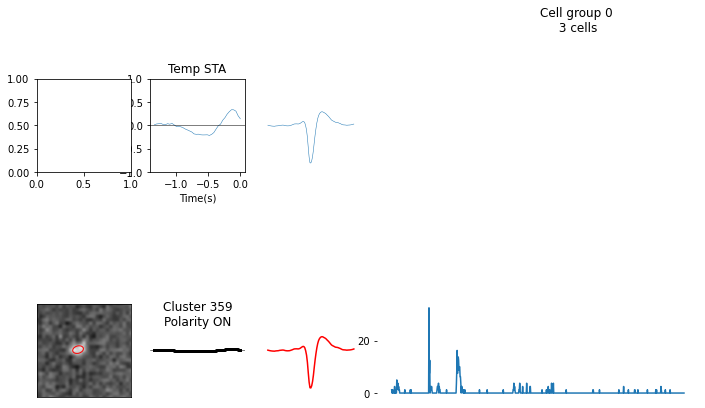

In [14]:
exp = 20211208

pup = 0

cols = ['C0','C1','C2','C3']

from matplotlib import gridspec

for icluster in range(len(np.unique(model.labels_)))[0:]:
    idx_cluster = np.where(model.labels_==icluster)[0]
    print(len(idx_cluster))

    gs = gridspec.GridSpec(len(idx_cluster)+2,10)
    
    if len(idx_cluster)<7:
        yspan = 2
    else:
        yspan=-2
        
    fig = figure(figsize=(20,(len(idx_cluster)+yspan)*2))
    plt.suptitle("Cell group {}\n {} cells".format(icluster, len(idx_cluster)))

    #-------------------------------
    # Loop cells in cluster
    line = 2
    STAs = np.zeros(40)
    STAcount = 0
    waves = np.zeros(101)
    wavecount = 0
    for index in sorted(idx_cluster):
        cell_nb = selected_cells[index]
        
        #### Clustering results
        
        #-----------------
        # Plot temp STA
        ax= subplot(gs[line,1])
        
        ax.set_ylim([-4,4])
        ax.axis("off")
        ax.set_aspect(0.075)
        ax.step(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],'k',lw=3)
        polarity = cell_data[cell_nb]["polarity"]
        ax.set_title('Cluster ' + str(cell_nb) + '\nPolarity '+polarity)
        ax.axhline(0,color='k',lw=0.5)
        
        STAs += cell_data[cell_nb]["temporal_sta"]
        STAcount += 1
        
        #-----------------
        # Plot temp STA avg
        ax= subplot(gs[0,1])
        
        ax.set_title('Temp STA')
        ax.set_ylim([-1,1])
        ax.plot(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],lw=0.5)
        ax.axhline(0,color='k',lw=0.5)
        ax.set_xlabel('Time(s)')
        #-----------------
        # plot Spatial STA
        ax= subplot(gs[line,0])
                
        ax.imshow(cell_data[cell_nb]["spatial_sta"], cmap='gray',interpolation='gaussian')
        ax.set_xlim(16,44)
        ax.set_ylim(44,16)
        ax.set_aspect('equal')
        #ax.set_title('Cluster' + str(cell_nb))
        ax.set_xticks([])
        ax.set_yticks([])
       
        #----------------
        #plot waveform
        ax= subplot(gs[line,2])
        
        wave = cell_data[cell_nb]["templates"]/abs(np.min(cell_data[cell_nb]["templates"]))
        ax.plot(wave,'r')
        ax.axis("off")
        ax.set_ylim([-1.25,1.25])
        waves+=wave
        wavecount+=1
        
        ax= subplot(gs[0,2])
        ax.plot(wave,lw=0.5)
        ax.axis("off")
        ax.set_ylim([-1.25,1.25])
        #-----------------
        # plot Euler
        ax= subplot(gs[line,3:6])
        
        cell_index=selected_cells.index(cell_nb)
        ax.plot(np.linspace(0,32,800),cell_data[cell_nb]["psth"])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        plt.locator_params(axis="y", nbins=3)
        
        #-----------------
        # plot Ellipse
        x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(cell_data[cell_nb]["spatial_sta"])
        
        x0, y0, width, height, angle = get_ellipse_parameters(parameters, factor=1)
        xy = (x0, y0)

        ax= subplot(gs[line,0])
        ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='r',lw=1)
        ax.add_patch(ellipse)
        
        ax= subplot(gs[0,0])
        ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='k',lw=1)
        ax.add_patch(ellipse)
        
        ##### Cells reponse to blur
        index_bl = where(blur_clusters == selected_cells[index])[0]
        print (selected_cells[index], blur_clusters[index_bl])
        if len(index_bl) > 0:
            index_bl = index_bl[0]
            max_act = nanmax(spike_counts_mean[index_bl])

            for src in range(Nsources):
                ax = fig.add_subplot(gs[line, src + 6])
                for iImg in range(Nimgs):
                    ax.plot(dFs, spike_counts_mean[index_bl, iImg, pup, :, src],'-', \
                            color=cols[iImg])
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    ax.set_ylim(0,1.5*max_act)
                    ax.set_xlim(0, 9)
                    ax.set_xticks(dFs[::2])
                    if line == 2:
                        ax.set_title('Ecc = {}°'.format(sourcesEcc[src]))
                        ax.set_xticklabels([])
                    if src == 0:
                        ax.set_ylabel('Spike cnt')
                    else:
                        ax.set_yticks([])
                    if line == len(idx_cluster)+1:
                        ax.set_xlabel('Defocus (D)')
                    else:
                        ax.set_xticks([])
                        
#                         ax.legend(frameon=False, fontsize = 8)
        
        line+=1
    #-----------------
    # avg STA
    STAs = STAs/STAcount
    ax= subplot(gs[0,1])
    ax.plot(np.linspace(-40/30,0,40),STAs,'k',lw=2)
    ax.set_ylim([-2,2])
    ax.set_aspect(0.075)
    ax.axis("off")
    
    #-----------------
    # avg wave
    waves=waves/wavecount
    ax= subplot(gs[0,2])
    ax.set_title('Waveform')
    
    ax.plot(waves,'r',lw=2)
    ax.set_ylim([-1.25,1.25])
    #ax.set_aspect(0.075)
    ax.axis("off")
    
    #-----------------
    # size ellipses
    ax= subplot(gs[0,0])
    
    ax.set_title('Ellipses')
    ax.set_xlim(16,44)
    ax.set_ylim(44,16)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
        
    #-----------------
    # mean psth
    ax= subplot(gs[0,3:6])
    ax.set_title('Euler psth')
    
    ax.plot(np.linspace(0,32,320),np.mean(psth_z[idx_cluster,:], 0),'g')
    ax.axis("off")

    #-----------------
    # plot euler stim
    euler_vec= get_euler()
    ax= subplot(gs[1,3:6])
    
    ax.plot(np.linspace(0,32,1600),euler_vec[150:1750,1], color='k')
    ax.set_yticks([])
    ax.set_ylim([-100,350])
    ax.set_xlabel('Time(s)')
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax= subplot(gs[1,2])
    ax.text(0.5,0.5 ,"Chirp stimulus profile")
    ax.axis("off")
    
    PDF_folder = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/RGC typing/'
    fsave = PDF_folder +'exp'+str(exp)+'_clustype' + str(icluster) + '_with_blur'
    
    fig.savefig(fsave+'.png',format='png',dpi=250)
    close(fig)  
